In [ ]:
# every code snippet with no source and not marked as AI generated is from the professors github repository

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [ ]:
import random
import os

# Set a fixed seed value
SEED = 12345

# 1. Set Python's built-in random module seed
random.seed(SEED)

# 2. Set NumPy random seed
np.random.seed(SEED)

# 3. Set TensorFlow seed
tf.random.set_seed(SEED)

# 4. Set environment variables (affects some backend randomness)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Optional: control inter-op and intra-op parallelism for determinism
# (can slightly slow down training, but improves reproducibility)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [42]:
df = pd.read_csv('online_shoppers_intention.csv')

df.head() 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.00,0,0.00,1,0.00,0.20,0.20,0.00,0.00,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.00,0,0.00,2,64.00,0.00,0.10,0.00,0.00,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.00,0,0.00,1,0.00,0.20,0.20,0.00,0.00,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.00,0,0.00,2,2.67,0.05,0.14,0.00,0.00,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.00,0,0.00,10,627.50,0.02,0.05,0.00,0.00,Feb,3,3,1,4,Returning_Visitor,True,False


In [43]:
df.shape

(12330, 18)

In [44]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [45]:
df['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

In [46]:
df = df.drop(df[df["VisitorType"] == "Other"].index)

df['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10551
New_Visitor           1694
Name: count, dtype: int64

In [47]:
df['Month'].value_counts()

Month
May     3364
Nov     2976
Mar     1907
Dec     1665
Oct      549
Sep      448
Aug      433
Jul      432
June     287
Feb      184
Name: count, dtype: int64

In [48]:
season_map = {
    "Dec": "Winter", "Jan": "Winter", "Feb": "Winter",
    "Mar": "Spring", "Apr": "Spring", "May": "Spring",
    "June": "Summer", "Jul": "Summer", "Aug": "Summer",
    "Sep": "Fall",   "Oct": "Fall",   "Nov": "Fall"
}

season_to_number = {
    "Winter": 1,    "Spring": 2, "Summer": 3, "Fall": 4
}


df['Month'] = df['Month'].map(season_map)


df['Month'] = df['Month'].map(season_to_number)

df.head() 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.00,0,0.00,1,0.00,0.20,0.20,0.00,0.00,1,1,1,1,1,Returning_Visitor,False,False
1,0,0.00,0,0.00,2,64.00,0.00,0.10,0.00,0.00,1,2,2,1,2,Returning_Visitor,False,False
2,0,0.00,0,0.00,1,0.00,0.20,0.20,0.00,0.00,1,4,1,9,3,Returning_Visitor,False,False
3,0,0.00,0,0.00,2,2.67,0.05,0.14,0.00,0.00,1,3,2,2,4,Returning_Visitor,False,False
4,0,0.00,0,0.00,10,627.50,0.02,0.05,0.00,0.00,1,3,3,1,4,Returning_Visitor,True,False


In [49]:
df['TrafficType'].value_counts()

TrafficType
2     3902
1     2444
3     2045
4     1069
13     737
10     447
6      443
8      342
5      259
11     246
20     146
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: count, dtype: int64

In [50]:
# There was just a short description of the variable TrafficType in the data documentation.
# It refers to the source the customer came from.
# Since there are 20 different values and no description, what value means what,
# I will invent 4 categories: social media (1-5), search engines (6-10), direct (11-15), others (16-20).
# I know that you would not invent data in real life, but in a real project, I would most certainly know, 
# what the values mean and it is very likely that I could group them in a similar way.



def map_traffic_type(x):
    if 1 <= x <= 5:
        return 1   # Social Media
    elif 6 <= x <= 10:
        return 2   # Search Engines
    elif 11 <= x <= 15:
        return 3   # Direct
    elif 16 <= x <= 20:
        return 4   # Others
    else:
        return 0

df['TrafficType'] = df['TrafficType'].apply(map_traffic_type) 



In [51]:
# The same applies to Region. I will invent 4 categories: North, Central, South


print(df['Region'].value_counts())

def map_region(x):
    if 1 <= x <= 3:
        return 1   # North
    elif 4 <= x <= 6:
        return 2   # Central
    elif 7 <= x <= 9:
        return 3   # South
    else:
        return 0

df['Region'] = df['Region'].apply(map_traffic_type) 

Region
1    4772
3    2395
4    1177
2    1131
6     804
7     759
9     456
8     433
5     318
Name: count, dtype: int64


In [52]:
df["Browser"].value_counts()

Browser
2     7940
1     2456
4      733
5      465
6      174
10     162
8      135
3      105
7       49
12      10
13       9
11       6
9        1
Name: count, dtype: int64

In [53]:
from sklearn.preprocessing import OneHotEncoder

variables_hot = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
hot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = hot_encoder.fit_transform(df[variables_hot]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables_hot)

In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

variables_label = ['VisitorType', 'Weekend']

df[variables_label] = df[variables_label].apply(label_encoder.fit_transform)

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4
0,0,0.00,0,0.00,1,0.00,0.20,0.20,0.00,0.00,...,0,0,0,0,1,0,1,0,0,0
1,0,0.00,0,0.00,2,64.00,0.00,0.10,0.00,0.00,...,0,0,0,0,1,0,1,0,0,0
2,0,0.00,0,0.00,1,0.00,0.20,0.20,0.00,0.00,...,0,0,0,0,0,1,1,0,0,0
3,0,0.00,0,0.00,2,2.67,0.05,0.14,0.00,0.00,...,0,0,0,0,1,0,1,0,0,0
4,0,0.00,0,0.00,10,627.50,0.02,0.05,0.00,0.00,...,0,0,0,0,1,0,1,0,0,0


In [55]:
corr_matrix = df.corr()['Revenue']
corr_matrix.sort_values(ascending=False)

Revenue                    1.00
PageValues                 0.49
Month_4                    0.17
ProductRelated             0.16
ProductRelated_Duration    0.15
Administrative             0.14
Informational              0.10
Administrative_Duration    0.09
Informational_Duration     0.07
OperatingSystems_2         0.06
TrafficType_2              0.04
Weekend                    0.03
TrafficType_4              0.02
Browser_5                  0.02
Browser_4                  0.01
Browser_10                 0.01
OperatingSystems_4         0.01
Region_1                   0.01
Browser_12                 0.01
Browser_13                 0.01
TrafficType_1              0.00
OperatingSystems_5         0.00
Browser_11                 0.00
Browser_8                  0.00
OperatingSystems_7        -0.00
Browser_2                 -0.00
Browser_9                 -0.00
OperatingSystems_8        -0.00
OperatingSystems_6        -0.01
Month_3                   -0.01
Browser_7                 -0.01
Browser_

In [56]:
df['Revenue'] = df['Revenue'].replace({
    True: '1: Revenue',
    False: '0: No_Revenue'
})

df['Revenue'].value_counts()

Revenue
0: No_Revenue    10353
1: Revenue        1892
Name: count, dtype: int64

In [57]:
X = df.drop('Revenue', axis=1)
y_temp = df['Revenue']

print(y_temp)

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)

print(le.classes_)

categories = list(le.classes_)



0        0: No_Revenue
1        0: No_Revenue
2        0: No_Revenue
3        0: No_Revenue
4        0: No_Revenue
             ...      
12325    0: No_Revenue
12326    0: No_Revenue
12327    0: No_Revenue
12328    0: No_Revenue
12329    0: No_Revenue
Name: Revenue, Length: 12245, dtype: object
['0: No_Revenue' '1: Revenue']


In [58]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
5,ProductRelated_Duration,869036.99
8,PageValues,167275.94
1,Administrative_Duration,41177.40
3,Informational_Duration,34869.34
4,ProductRelated,19224.61
0,Administrative,1125.93
2,Informational,358.97
15,Month_4,228.16
13,Month_2,96.24
18,OperatingSystems_3,47.37


In [59]:
# Based on the scores, it seems that browsers do not play a significant role so I will drop them
# The same applies to BounceRates and ExitRates



browser_colums = []

for col in df.columns:
    if 'Browser_' in col:
        browser_colums.append(df[col].name) 

X = X.drop(browser_colums, axis=1)

X = X.drop(['BounceRates', 'ExitRates'], axis=1)




In [60]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [61]:
import keras_tuner

def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=4, max_value=96, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(hp.Float("l1", min_value=0.025, max_value=0.35, sampling="log"))
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            hp.Float("rate", min_value=0.1, max_value=0.5, step=0.025)
            ))

    # try additional layers, 1-3 extra layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=8, max_value=96, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(len(categories), activation="softmax"))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy', metrics=['accuracy']
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="optimizations1",
    project_name="classification1test",
)

# start searching
tuner.search(X_train, y_train, epochs=250, validation_data=(X_val, y_val))

Trial 5 Complete [00h 03m 49s]
val_accuracy: 0.8913989961147308

Best val_accuracy So Far: 0.8913989961147308
Total elapsed time: 00h 19m 27s


In [62]:
tuner.results_summary()

Results summary
Results in optimizations1\classification1test
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units_0: 28
activation: relu
l1: 0.05038207330409377
dropout: False
num_layers: 3
units_1: 88
lr: 0.00022146929820420383
rate: 0.125
units_2: 96
units_3: 8
Score: 0.8913989961147308

Trial 2 summary
Hyperparameters:
units_0: 20
activation: relu
l1: 0.0278130575086071
dropout: False
num_layers: 1
units_1: 32
lr: 0.04215502729869911
rate: 0.4
units_2: 76
Score: 0.8892215490341187

Trial 1 summary
Hyperparameters:
units_0: 20
activation: relu
l1: 0.18413382715338444
dropout: False
num_layers: 2
units_1: 80
lr: 0.000440634515862116
rate: 0.2
units_2: 8
Score: 0.8886772096157074

Trial 3 summary
Hyperparameters:
units_0: 8
activation: relu
l1: 0.054921988390215906
dropout: True
num_layers: 2
units_1: 24
lr: 0.00012237276005853213
rate: 0.17500000000000002
units_2: 88
Score: 0.8881328403949738

Trial 0 summary
Hyperparameters:


In [63]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 28)             │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │         2,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │         8,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,814 (50.05 KB)

 Trainable params: 12,758 (49.84 KB)

 Non-trainable params: 56 (224.00 B)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint('best_model_classification1_kt.keras', monitor='val_accuracy', mode='max', save_best_only=True)

callback_list = [mc]



model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(28, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.05038207330409377)),
        layers.Dense(88, activation="relu"),
        layers.Dense(96, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.00022146929820420383

model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 28)             │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 56)             │         1,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 44)             │         2,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 36)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            74 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,756 (26.39 KB)

 Trainable params: 6,700 (26.17 KB)

 Non-trainable params: 56 (224.00 B)

In [65]:

model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/500


268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8437 - loss: 0.4608 - val_accuracy: 0.8846 - val_loss: 0.3834
Epoch 2/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8890 - loss: 0.3408 - val_accuracy: 0.8835 - val_loss: 0.3425
Epoch 3/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8878 - loss: 0.3112 - val_accuracy: 0.8819 - val_loss: 0.3174
Epoch 4/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.2926 - val_accuracy: 0.8813 - val_loss: 0.3087
Epoch 5/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 0.2843 - val_accuracy: 0.8862 - val_loss: 0.2937
Epoch 6/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8915 - loss: 0.2794 - val_accuracy: 0.8857 - val_loss: 0.2852
Epoch 7/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8889 - loss: 0.2743 - val_accuracy: 0.8933 - val_loss: 0.2907
Epoch 8/500
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8932 - loss: 0.2726 - val_accuracy: 0.8900

<Axes: >

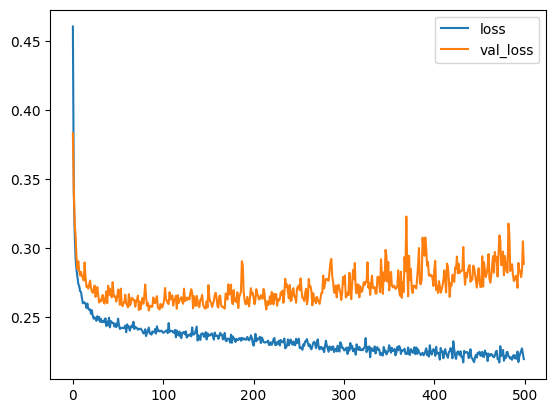

In [66]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

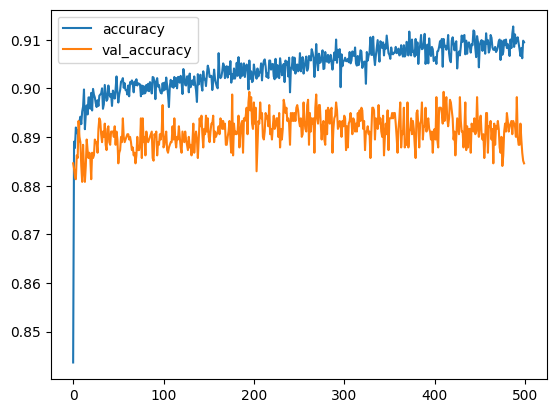

In [ ]:


loss_df[['accuracy', 'val_accuracy']].plot()

In [ ]:


print(y_test.shape)       
print(X_test.shape)



print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

(1837, 2)
(1837, 28)
Test data evaluation:
[0.2627714276313782, 0.8916711807250977]

Train data evaluation:
[0.1985505074262619, 0.9183292388916016]


In [69]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Axes: >

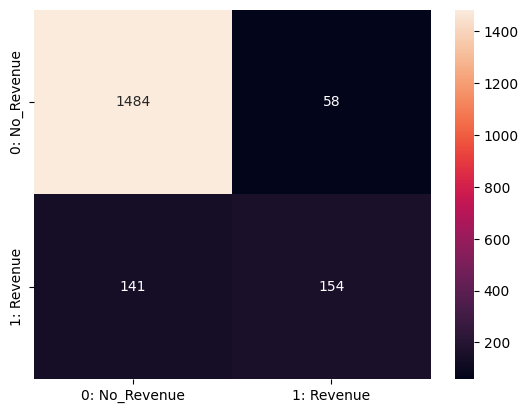

In [70]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

In [ ]:



print(classification_report(y_test, test_predictions, target_names=categories))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

               precision    recall  f1-score   support

0: No_Revenue       0.91      0.96      0.94      1542
   1: Revenue       0.73      0.52      0.61       295

     accuracy                           0.89      1837
    macro avg       0.82      0.74      0.77      1837
 weighted avg       0.88      0.89      0.88      1837


Model overall accuracy: 89.17%


In [72]:

roc_auc_score(y, model.predict(X), multi_class="ovr")

383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step


0.9415111291290591